# DATA UNDERSTANDING AND PREPROCESSING

by ChunkDevs (Group 1)

In this notebook we will initially analyze the **`cyberbullying_tweets`** dataset, created by Jason Wang, Kaiqun Fu and Chang-Tien Lu.

**THE DATASET**

This dataset contains a collection of messages from the social media "Twitter" (now called "X"). The harmful messages can be the telling of a cyberbullying situation, or the offense itself. This dataset has **multilanguage** tweets.

**THE PROCEDURE**

In the data understanding phase, we will get a deeper insight among the data, in order to know hot to deal to eventual issues related to the internal composition of the dataset.

Secondly, we will create our datasets that will be used during the implementation of the models. Since we found that the main dataset is a collection of multilanguage tweets we decided to create two different dataset:

- The first one which mantains the language diversity among the tweets and that will be used with the RoBERTa transformer.

- For the second dataset, only the english tweets will be filtered from the original dataset by the use of the `fasttext`, `lingua-language-detector` and the `langdetect` libraries. This is the dataset that will be used with every model, in order to have results that do not risk to be lowered by the presence of more than one language. The future analysis will also confirm that the majority of the tweets are written in english.

Both of the dateset will be splitted in DEV and TEST dateset, separing the 90% of the tweets in the dev-set and the remaining 10% in the test-set.

After this operations, we will proceed with the text cleaning phase **only for the dev sets** in order to keep the test sets untouched during the testing phase of every model and with the aim of seeing the performances of every machine learning classifier with raw and unprocessed text.

Giving an anticipation, every model will be used in a binary and a multiclass classification task, so we will try to implements models that will be able to distinguish among not cyberbullying tweets and cyberbullying messages in the first task, and then they will also identify the different cyberbullying types of the harmful tweets in the second challenge

**THE CHUNKDEVS LIBRARY**

Since we are going to deal with different operations, repeated for different Machine Learning models and Natural Language Processing tasks, we decided to create our group library **`_chunkdevs`**, which contains classes and function that will be used in the notebooks, in order to make the code simpler and summarized. The library has 3 main folders:

- **`data_functions`**: It contains functions strictly related to dataset operations, like removing the empty records or filtering the dataset according to some criteria.
  
- **`preprocessor`**:  It is used for the text processing operations, i.e. cleaning the texts or detecting the message language.
  
- **`models`**: a set of classes used for implement the ML models (transformers or other classifiers), save/ load configurations of hyperparamenters, results, images and classification reports

In [ ]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [ ]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from _chunkdevs.preprocessor import Cleaner, LanguageDetector
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split

# DATA LOADING

In [ ]:
data_path = os.path.join(root_path, "data", "raw", "cyberbullying_tweets.csv")
data = pd.read_csv(data_path, encoding="utf-8", skipinitialspace=True)

In [ ]:
data.head(5)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
data.shape, np.unique(data["cyberbullying_type"])

((47692, 2),
 array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
        'other_cyberbullying', 'religion'], dtype=object))

<div style="font-size: 16px">
<br>
Looking at the dataset, we can see that we have two columns:
- the `tweet_text` column, which includes all the tweets collected by the authors of the dataset, (almost 48000)
- the `cyberbullying_type` column, which contains the labels assigned to every message.

We have 6 different labels: `'age'`, `'ethnicity'`, `'gender'`, `'not_cyberbullying'`, `'other_cyberbullying'` and `'religion'`
<br>
</div>

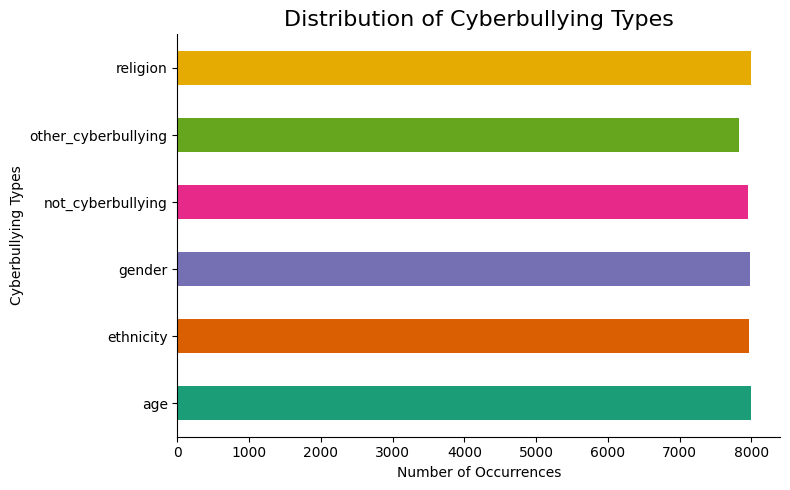

In [ ]:
plt.figure(figsize=(8, 5))

colors = sns.color_palette('Dark2')
data.groupby('cyberbullying_type').size().plot(kind='barh', color=colors)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Distribution of Cyberbullying Types', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=10)
plt.ylabel('Cyberbullying Types', fontsize=10)

plt.tight_layout()
plt.show()

<div style="font-size: 16px;">
    
We have a **balanced distribution** among the classes.


</div>

# DATA UNDERSTANDING

<div style="font-size: 16px">

In this code we filter out rows with duplicated tweets, creating a subset of the dataset. Then, with the `value_counts` method, we calculate the distribution of different cyberbullying types within these duplicated tweets. A bar plot is generate to visualize this distribution.
<br>
</div>

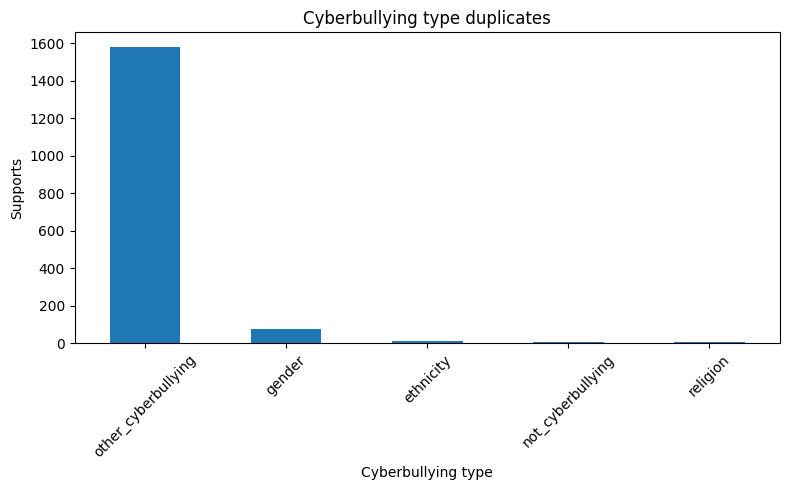

In [ ]:
duplicated_row = data[data["tweet_text"].duplicated()]
distributions = duplicated_row["cyberbullying_type"].value_counts()

plt.figure(figsize=(8, 5))
distributions.plot(kind='bar')
plt.title('Cyberbullying type duplicates')
plt.xlabel('Cyberbullying type')
plt.ylabel('Supports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'understanding_preprocessing', 'cyb_duplicates_original_data.png'))
plt.show()

In [ ]:
data = data.drop_duplicates(subset=["tweet_text"])

<div style="font-size: 16px">

    
At a first sight, it is possible to notice that the `other_cyberbullying` class has nearly 1500 duplicate tweets, whereas the other classes have a much lower numbers of duplicates. These duplicates have been removed from the dataset.

<br>
</div>

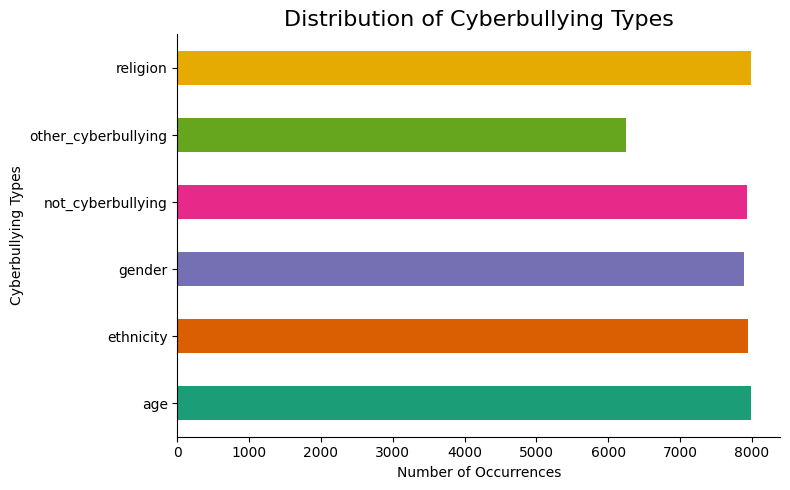

In [ ]:
plt.figure(figsize=(8, 5))

colors = sns.color_palette('Dark2')
data.groupby('cyberbullying_type').size().plot(kind='barh', color=colors)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Distribution of Cyberbullying Types', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=10)
plt.ylabel('Cyberbullying Types', fontsize=10)

plt.tight_layout()
plt.show()

<div style="font-size: 16px;">
    
Now we have an **unbalanced distribution** among the classes. It will be necessary to balance again the dataset after the train-test split


</div>

<div style="font-size: 16px">
<br><br>
    
Since the `cyberbullying types` labels are only in a string format, we decided to use a dictionary to map each type of cyberbullying to a unique integer in an alphabetic order and create a column with the number associated to each label. Secondly, a new column is created to allow binary classification, assigning the label 0 for not cyberbullying tweets and the label 1 for cyberbullying messages.

It is necessary to consider that the not cyberbullying tweets will be very lower than the harmful messages (nearly 1/6 of all the tweets). Therefore, for the binary class we will have to deal with a case of **unbalanced learning**.

</div>

In [ ]:
# A dictionary is created to map each type of cyberbullying to a unique integer
multiclass_map_pattern = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2,
    "not_cyberbullying": 3,
    "other_cyberbullying": 4,
    "religion": 5
}

# A new column is created to allow binary classification
data["cyberbullying_type_bin"] = np.where(data["cyberbullying_type"] != 'not_cyberbullying', 1, 0).astype('int64')

# Another new column is created for multiclass classification, mapping the categorical labels with the corrisponding integers defined in the dictionary
data["cyberbullying_type_multi"] = data["cyberbullying_type"].map(multiclass_map_pattern)

In [ ]:
data

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,3
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,1,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,1,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,1,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1,1


# DATA PREPARATION

## MULTILANGUAGE DATASET

### DEV-TEST SPLITTING

<div style="font-size: 16px;">
    
Sets of parameters for data splitting:

*   `RANDOM_STATE`: ensures reproducibility of the data splitting by fixing a random seed (in this case, 42);
*   `TEST_SIZE`: is set to 0.1, in order to have as much training data as possible.

</div>

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = .1

<div style="font-size: 16px;">

Split of the dataset into devolopment and test set (0.9% for development set and 0.1% for test set).

The `stratify` parameter is set to *y_multi*: this means that the proportion of each class label of the "cyberbullyng_type" column is preserved in both the development and test sets.

</div>

In [ ]:
y_multi = data["cyberbullying_type"]

dev_set_multi, test_set_multi = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_multi)

print(dev_set_multi.shape, test_set_multi.shape)

(41415, 4) (4602, 4)


### DEV-SET TEXT CLEANING

<div style="font-size: 16px;">
    

In this phase only the dev-set will be pre-processed. Fistly, the texts will be cleaned, for example removing the mentions and the url links. Secondly, the dataset will be re-balanced to mantain the correct distribution of the classes. for this kind of operations, we decided to create our personalized classes inside the **`_chunkdevs`** library that will deal with these issues.  

We define also a dictionary `PATTERNS`, which contains a list of tuples: each tuples consists of a regular expression pattern and its corresponding replacement string.

These patterns represents common English contractions and informal abbreviations that are often used in social media like X (formerly twitter). The dealing of english contractions is one of the most common text processing appraches; we decided to not normalize the *'s* contraction because, dependently from the context, it could be a possessive or an abbreviation of *is* or *has*. A solution to this problem could be the implementation of a model that is able to analyze the context and classify the true meaning of this contracted form.

</div>


In [ ]:
PATTERNS = {
    "contracted" : [
        (r"\bcan't\b", " can not "),
        (r"\bn't\b", " not "),
        (r"\baren't\b", " are not "),
        (r"\bisn't\b", " is not "),
        (r"\bwasn't\b", " was not "),
        (r"\bwon't\b", " will not "),
        (r"\bweren't\b", " were not "),
        (r"\bdoesn't\b", " does not "),
        (r"\bdidn't\b", " did not "),
        (r"\bhadn't\b", " had not "),
        (r"\bppl\b", " people "),
        (r"\bu\b", " you "),
        (r"\bU\b", " You ")
    ]
}

For the **text cleaning** phase, we are using our `Cleaner` class, imported from `_chunkdevs.preprocessor`.

The Cleaner cleans the text data using various methods, the  ones that we decided to use are the following:

- `_mentions_remover`: Remove mentions from text. We believe that mentions to other users are not very informative to our type of task, and then we decided to remove them.
    
- `_newlines_remover`: Replace newlines and carriage returns ("**\n**","**\r**") with space and convert text to lowercase. This kind of characters can always appear in to the text, especially when the codifying language is different, removig them is one of the most common text cleaning procedures
    
- `_non_ascii_remover`: Remove non-ASCII characters from text.
    
- `_repeated_letters_remover`: Remove repeated letters in words, normalizing words like "*baaad*" to "*bad*" ecc.
    
- `_tags_html_remover`: Remove HTML tags from text.
    
- `_contracted_form`: Expand contracted forms in text based using the patterns that we introduced before. The patterns must be passed as a hyperparameter of the Cleaner class.
    
- `_links_remover`: Remove links from text for the same reason as the mentions. We also found that there are some tweets have the same text, but with a different link, and tweets that have only an url link
    
- `_hashs_remover`: Remove hashtags from text. The case of the hashtag is more particular when dealing with messages from twitter. The hashtag are used as words inside the sentences, so we decided to only remove the "*#*" symbol while keeping the word after that.
    
- `emoji_remover`: Remove emojis from text using the emot library.
    
- `emoticons_remover`: Remove emoticons from text using the emot library. Unfortunately we cannot deal with this kind of character, but is necessary to consider that emojis and emoticons can be useful in tasks like emotion detection or toxicity/ cyberbullying classification

- `hypen_remover`: remover the hypen ("-") symbol, in order to separate the compounds in words that are more likely to be correctly placed in a word distribution.
    
- `text_cleaner`: Clean text using all the methods mentioned before.


<div style="font-size: 16px;">
    
We decided to keep numbers and punctuations, because they can be informative. For example, the age can be expressed as a number and therefore it could be used for identifying age cyberbullying. The new cleaned text are placed in the new `"tweet_text_cleaned"` column.

Another consideration is needed for the hashtags. At a first moment we tried to put the words with the hash symbol in a new column, in order to use it as a feature for classification. However, we found that the number of tweets with hashtags is much lower than expected, and that some hashtags like "*MKR*" (an acronym of My Kitchen Rules, a british tv series) are used in tweets labeled as gender, other cyberbullying or not cyberbullying, so they can not discriminate one class from the others. For this reasons, we decided to not continue with this approach.
</div>

In [ ]:
# An istance of the 'Cleaner' class is created with the predifined "patterns"
cleaner = Cleaner(patterns=PATTERNS)

# The "tweet_text_cleaned" column is added to the development dataset. This column contains the cleaned version of the "tweet text" column
dev_set_multi["tweet_text_cleaned"] = dev_set_multi["tweet_text"].apply(lambda text: cleaner.text_cleaner(text))

In [ ]:
dev_set_multi.shape

(41415, 5)

<div style="font-size: 16px;">
    
After the cleaning process, we found that some of the processed tweets where completely removed (i.e. tweets with only emojis or links). Therefore, they should be considered as missing values and they should be removed.

The `remove_empty_records` function, imported from `_chunkdevs.data_functions`, removes records of the `"tweet_text_cleaned"` column which contains empty or null values.

Moreover, some of the processed tweets are become equal to other tweets. This is due to the fact that some of them were differentiated only by links, mentions emojis ecc. Therefore, we decided to remove the duplicated messages from the `"tweet_text_cleaned"` column

</div>

In [ ]:
dev_set_multi = remove_empty_records(dev_set_multi, "tweet_text_cleaned")

Number of elements that were removed: 50


In [ ]:
# We calculate and print the number of duplicate elements in "tweet_text_cleaned" column
duplicates_multi = dev_set_multi["tweet_text_cleaned"].duplicated().sum()
print(f"Number of duplicated elements: {duplicates_multi}")

Number of duplicated elements: 237


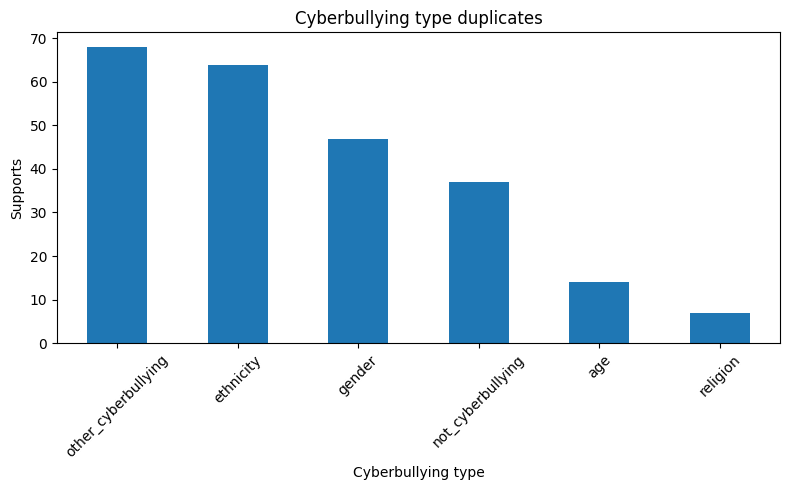

In [ ]:
duplicated_row = dev_set_multi[dev_set_multi["tweet_text_cleaned"].duplicated()]
distributions = duplicated_row["cyberbullying_type"].value_counts()

plt.figure(figsize=(8, 5))
distributions.plot(kind='bar')
plt.title('Cyberbullying type duplicates')
plt.xlabel('Cyberbullying type')
plt.ylabel('Supports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="font-size: 16px;">

As it is possible to notice, the distribution of the duplicates has changed.
</div>

In [ ]:
# Removal of duplicate entries from the "dev_set_multi" dataframe on the "tweet_text_cleaned" column
dev_set_multi = dev_set_multi.drop_duplicates(subset=["tweet_text_cleaned"])

# Removal of common tweets from the "dev_set_multi" dataframe on the "tweet_text_cleaned" column

common_tweets_dev_in_test = dev_set_multi['tweet_text'].isin(test_set_multi['tweet_text']).sum()
common_tweets_index_dev_in_test = dev_set_multi[dev_set_multi['tweet_text'].isin(test_set_multi['tweet_text'])].index

print(f"In the devset there are {common_tweets_dev_in_test} raw tweets in common with the tweets of testset.")

test_set_multi = test_set_multi.drop(index=common_tweets_index_dev_in_test)
dev_set_multi = dev_set_multi.drop(index=common_tweets_index_dev_in_test)


common_tweets_dev_in_test = dev_set_multi['tweet_text_cleaned'].isin(test_set_multi['tweet_text']).sum()
common_tweets_index_dev_in_test = dev_set_multi[dev_set_multi['tweet_text_cleaned'].isin(test_set_multi['tweet_text'])].index

print(f"In the devset there are {common_tweets_dev_in_test} clean tweets in common with the testset.")


dev_set_multi = dev_set_multi.drop(index=common_tweets_index_dev_in_test)


print(f"Shape of test_set_multi after the drops: {test_set_multi.shape}")
print(f"Shape of dev_set_multi  after the drops: {dev_set_multi.shape}")

In the devset there are 0 raw tweets in common with the tweets of testset.
In the devset there are 3 clean tweets in common with the testset.
Shape of test_set_multi after the drops: (4602, 4)
Shape of dev_set_multi  after the drops: (41125, 5)


<div style="font-size: 16px;">
<br>
    
We used this snippet of code to make sure that there are no more tweets in common between the deset and the test before the balancing, considering both the clean text and the raw text of the datasets

<br>
</div>

### DEV-SET AND TEST-SET BALANCING

<div style="font-size: 16px;">
    
The purpose of this operation is to prepare the multilingual dataset with an equal distribution of records across all cyberbullying types, based on the minimum number found among the different types in the `dev_set_multi_`.

In each iteration of the for loop, `sampled_group` is created by sampling `min_records_per_genre` number of records from `group_data`. This ensures that each group (cyberbullying type) contributes an equal number of records to the balanced dataset.

After balancing the dataset, `reset_index` is called on `data_balanced_multi` to reset the index of the DataFrame, dropping the old index and replacing it with a new sequential one.

</div>

In [ ]:
min_records_per_genre = dev_set_multi["cyberbullying_type"].value_counts().min()

data_balanced_multi = pd.DataFrame()

for group_name, group_data in dev_set_multi.groupby("cyberbullying_type"):
    sampled_group = group_data.sample(n=min_records_per_genre)
    data_balanced_multi = pd.concat([data_balanced_multi, sampled_group])

data_balanced_multi.reset_index(drop=True, inplace=True)

dev_set_multi = data_balanced_multi

In [ ]:
min_records_per_genre = test_set_multi["cyberbullying_type"].value_counts().min()

data_balanced_multi = pd.DataFrame()

for group_name, group_data in test_set_multi.groupby("cyberbullying_type"):
    sampled_group = group_data.sample(n=min_records_per_genre)
    data_balanced_multi = pd.concat([data_balanced_multi, sampled_group])

data_balanced_multi.reset_index(drop=True, inplace=True)

test_set_multi = data_balanced_multi

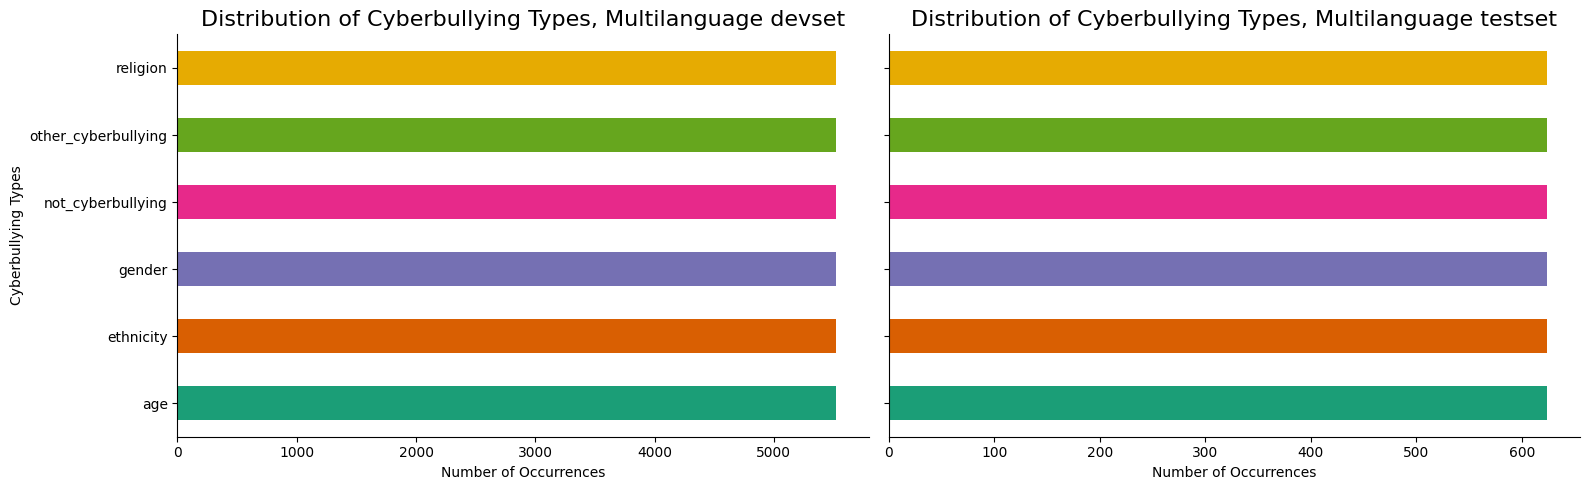

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
colors = sns.color_palette('Dark2')


dev_set_multi.groupby('cyberbullying_type').size().plot(kind='barh', color=colors, ax=axs[0])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_title('Distribution of Cyberbullying Types, Multilanguage devset', fontsize=16)
axs[0].set_xlabel('Number of Occurrences', fontsize=10)
axs[0].set_ylabel('Cyberbullying Types', fontsize=10)

test_set_multi.groupby('cyberbullying_type').size().plot(kind='barh', color=colors, ax=axs[1])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_title('Distribution of Cyberbullying Types, Multilanguage testset', fontsize=16)
axs[1].set_xlabel('Number of Occurrences', fontsize=10)
axs[1].set_ylabel('Cyberbullying Types', fontsize=10)

plt.tight_layout()
plt.show()

<div style="font-size: 16px;">

Once again, we have balanced classes for the devset and the testset. We decided to do the balancing after the split to lose as minimun tweets as possible.

<br>
</div>

In [ ]:
devset_shape = dev_set_multi.shape
testset_shape = test_set_multi.shape
devset_counts = np.unique(dev_set_multi["cyberbullying_type_multi"], return_counts=True)
testset_counts = np.unique(test_set_multi["cyberbullying_type_multi"], return_counts=True)


print(f"Dev set dimensions: {devset_shape}")
print(f"Dev set counts: {dict(zip(devset_counts[0], devset_counts[1]))}\n")
print(f"Test set dimensions: {testset_shape}")
print(f"Test set counts: {dict(zip(testset_counts[0], testset_counts[1]))}\n")

Dev set dimensions: (33114, 5)
Dev set counts: {0: 5519, 1: 5519, 2: 5519, 3: 5519, 4: 5519, 5: 5519}

Test set dimensions: (3744, 4)
Test set counts: {0: 624, 1: 624, 2: 624, 3: 624, 4: 624, 5: 624}



In [ ]:
dev_set_multi.head(5)

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi,tweet_text_cleaned
0,We high-five each other. Jimin has a smile on ...,age,1,0,we high five each other. jimin has a smile on ...
1,They are running out of evil plots ..trying to...,age,1,0,they are running out of evil plots ..trying to...
2,In high school i was bullied a lot. I never fe...,age,1,0,in high school i was bullied a lot. i never fe...
3,"Um, you seem to forget that 'the spoiled, brai...",age,1,0,"um, you seem to forget that 'the spoiled, brai..."
4,People bagging on the “Tall Girl” movie. Look ...,age,1,0,people bagging on the tall girl movie. look ju...


<div style="font-size: 16px;">

Summarizing, we splitted the dataset in dev and test set (~38000 tweet DEV, ~4800 tweets for TEST), and then we procedeed in cleaning only the dev set. After that, we balanced again the dataset, in order to mantain the same distribution of the classes. In the end, the dataset has 3 new columns:

- `cyberbullying_type_bin`: 0/1 labels (not cyberbullying/ cyberbullying) for binary classification,
- `cyberbullying_type_multi`: numerical labels for the multiclass claassification task,
- `tweet_text_cleaned`: the column with the cleaned text, only for the dev-set.

<br><br>
</div>

### DATA SAVING
Saving the new datasets in the appropriate folder

In [ ]:
dev_path = os.path.join(root_path, 'data', 'processed', 'multilanguage_dev_set.csv')
test_path = os.path.join(root_path, 'data', 'processed', 'multilanguage_test_set.csv')

dev_set_multi.to_csv(dev_path, index=False)
test_set_multi.to_csv(test_path, index=False)

name_dev = dev_path.split(os.path.sep)[-1]
name_test = test_path.split(os.path.sep)[-1]


save_report = f"| `{name_dev}` e `{name_test}` are correctly saved in: {os.path.join(root_path, 'data', 'processed')} |"

print("-"*len(save_report))
print(save_report)
print("-"*len(save_report))

---------------------------------------------------------------------------------------------------------------------------
| `multilanguage_dev_set.csv` e `multilanguage_test_set.csv` are correctly saved in: /home/m.sanna21/V_HLT/data/processed |
---------------------------------------------------------------------------------------------------------------------------


## ENGLISH DATASET

<div style="font-size: 16px;">

**Starting again from the original dataset**, we utilize the `LanguageDetector` class of our library to perform language detection on the text data stored in `"tweet_text"` column. With the `detector` variable we initialize an istance of the class, which provides access to methods for detecting language using three different libraries: `langdetect`, `fasttext` and `lingua`.

In order to filter the english tweet we decided to **keep only the tweets that are classified as english by every library**

From the `LanguageDetector` class we used the method `language_detector`, that allows to detect language using the specified language detection model. It is also possible to use `detector_langdetect`, `detector_langdetect` and the `detector_langdetect` separately.


</div>

### LANGUAGE FILTERING

In [ ]:
detector = LanguageDetector()

data["langdetect"] = data["tweet_text"].apply(lambda text: detector.detector_language(text, "langdetect"))
data["fasttext"] = data["tweet_text"].apply(lambda text: detector.detector_language(text, "fasttext"))
data["lingua"] = data["tweet_text"].apply(lambda text: detector.detector_language(text, "lingua"))

<div style="font-size: 16px;">

We create a dictionary `features` specifying criteria for selecting data from the dataframe based on the language detection results. Then `get_data_criteria` function is called, retaining rows where all the three libraries has classified the text as english. So, the resulting dataframe `data_en` will cointain only rows where the text is identified in that way.

</div>

In [ ]:
features = {
    "langdetect": ["en"],
    "fasttext": ["en"],
    "lingua": ["en"]
}

data_en = get_data_criteria(data, features)
data_en

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,3
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,1,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,1,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,1,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1,1


<div style="font-size: 16px;">

As anticipated, almost the 90% of the tweets are classified by every library as english tweets.

<br>

After that, the only-english dataset is splitted in dev and test set (90/10 also in this case), and we repeat the same procedure for cleaning and rebalancing  </div>

In [ ]:
# Looking for duplicate elements in "tweet_text" column
duplicates_multi = data_en["tweet_text"].duplicated().sum()
print(f"Number of duplicated elements: {duplicates_multi}")

Number of duplicated elements: 0


### DATA SPLITTING

In [ ]:
y_en = data_en["cyberbullying_type"]

dev_set_en, test_set_en = train_test_split(data_en, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_en)

print(dev_set_en.shape, test_set_en.shape)

(37013, 4) (4113, 4)


<div style="font-size: 16px;">

However, after the language filtering, the classes are very unbalanced. Therefore, we balance again the testset. The devset will be balanced after the cleaning procedure in order to lose the minimum tweets as possible.  

</div>

### DEV-SET CLEANING

In [ ]:
cleaner = Cleaner(patterns=PATTERNS)
dev_set_en["tweet_text_cleaned"] = dev_set_en["tweet_text"].apply(lambda text: cleaner.text_cleaner(text))

In [ ]:
dev_set_en = remove_empty_records(dev_set_en, "tweet_text_cleaned")

Number of elements that were removed: 1


In [ ]:
duplicates_en = dev_set_en["tweet_text_cleaned"].duplicated().sum()
print(f"Number of duplicated elements: {duplicates_en}")

Number of duplicated elements: 88


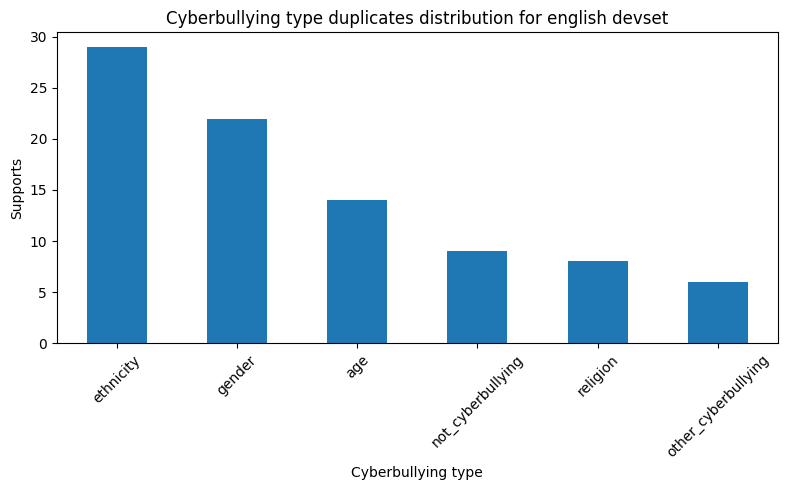

In [ ]:
duplicated_row = dev_set_en[dev_set_en["tweet_text_cleaned"].duplicated()]
distributions = duplicated_row["cyberbullying_type"].value_counts()

plt.figure(figsize=(8, 5))
distributions.plot(kind='bar')
plt.title('Cyberbullying type duplicates distribution for english devset')
plt.xlabel('Cyberbullying type')
plt.ylabel('Supports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
dev_set_en = dev_set_en.drop_duplicates(subset=["tweet_text_cleaned"])

In [ ]:
# Removal of common tweets from the "dev_set_en" dataframe on the "tweet_text_cleaned" column

common_tweets_dev_in_test_en = dev_set_en['tweet_text'].isin(test_set_en['tweet_text']).sum()
common_tweets_index_dev_in_test_en = dev_set_en[dev_set_en['tweet_text'].isin(test_set_en['tweet_text'])].index

print(f"In the devset there are {common_tweets_dev_in_test_en} raw tweets in common with the tweets of the testset.")

dev_set_en = dev_set_en.drop(index=common_tweets_index_dev_in_test_en)

common_tweets_dev_in_test_clean_en = dev_set_en['tweet_text_cleaned'].isin(test_set_en['tweet_text']).sum()
common_tweets_index_dev_in_test_clean_en = dev_set_en[dev_set_en['tweet_text_cleaned'].isin(test_set_en['tweet_text'])].index

print(f"In the devset there are {common_tweets_dev_in_test_clean_en} clean tweets in common with the testset.\n")

dev_set_en = dev_set_en.drop(index=common_tweets_index_dev_in_test_clean_en)

print(f"Shape of test_set_en after the drops: {test_set_en.shape}")
print(f"Shape of dev_set_en after the drops: {dev_set_en.shape}")

In the devset there are 0 raw tweets in common with the tweets of the testset.
In the devset there are 1 clean tweets in common with the testset.

Shape of test_set_en after the drops: (4113, 4)
Shape of dev_set_en after the drops: (36923, 5)


### DEVSET AND TESTSET BALANCING

In [ ]:
min_records_per_genre = test_set_en["cyberbullying_type"].value_counts().min()

data_balanced_eng = pd.DataFrame()

for group_name, group_data in test_set_en.groupby("cyberbullying_type"):
    sampled_group = group_data.sample(n=min_records_per_genre)
    data_balanced_eng = pd.concat([data_balanced_eng, sampled_group])

data_balanced_eng.reset_index(drop=True, inplace=True)

test_set_en = data_balanced_eng

In [ ]:
min_records_per_genre = dev_set_en["cyberbullying_type"].value_counts().min()

data_balanced_eng = pd.DataFrame()

for group_name, group_data in dev_set_en.groupby("cyberbullying_type"):
    sampled_group = group_data.sample(n=min_records_per_genre)
    data_balanced_eng = pd.concat([data_balanced_eng, sampled_group])

data_balanced_eng.reset_index(drop=True, inplace=True)

dev_set_en = data_balanced_eng

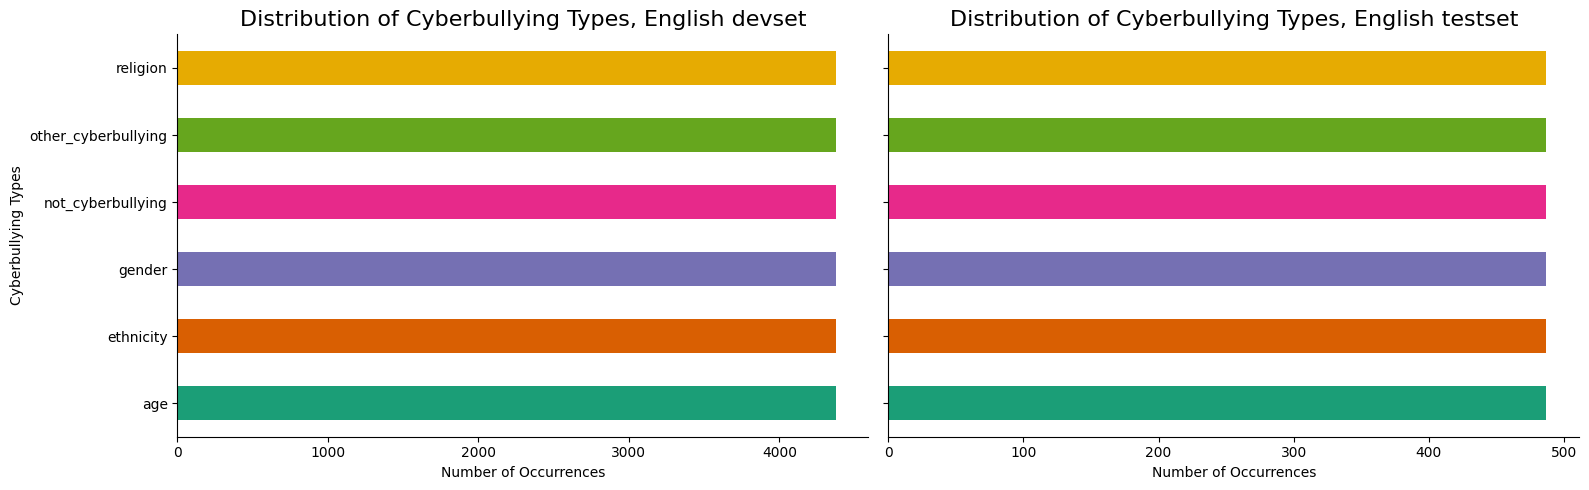

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
colors = sns.color_palette('Dark2')


dev_set_en.groupby('cyberbullying_type').size().plot(kind='barh', color=colors, ax=axs[0])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_title('Distribution of Cyberbullying Types, English devset', fontsize=16)
axs[0].set_xlabel('Number of Occurrences', fontsize=10)
axs[0].set_ylabel('Cyberbullying Types', fontsize=10)

test_set_en.groupby('cyberbullying_type').size().plot(kind='barh', color=colors, ax=axs[1])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_title('Distribution of Cyberbullying Types, English testset', fontsize=16)
axs[1].set_xlabel('Number of Occurrences', fontsize=10)
axs[1].set_ylabel('Cyberbullying Types', fontsize=10)

plt.tight_layout()
plt.show()

<div style="font-size: 16px;">

Once again, we have balanced classes for the devset and testset.

<br>
</div>

In [ ]:
devset_shape = dev_set_en.shape
testset_shape = test_set_en.shape
devset_counts = np.unique(dev_set_en["cyberbullying_type_multi"], return_counts=True)
testset_counts = np.unique(test_set_en["cyberbullying_type_multi"], return_counts=True)


print(f"Dev set dimensions: {devset_shape}")
print(f"Dev set counts: {dict(zip(devset_counts[0], devset_counts[1]))}\n")
print(f"Test set dimensions: {testset_shape}")
print(f"Test set counts: {dict(zip(testset_counts[0], testset_counts[1]))}")

Dev set dimensions: (26238, 5)
Dev set counts: {0: 4373, 1: 4373, 2: 4373, 3: 4373, 4: 4373, 5: 4373}

Test set dimensions: (2922, 4)
Test set counts: {0: 487, 1: 487, 2: 487, 3: 487, 4: 487, 5: 487}


### DATA SAVING
Saving the new datasets in the appropriate folder

In [ ]:
dev_eng_path = os.path.join(root_path, 'data', 'processed', 'english_tweets_dev_set.csv')
test_eng_path = os.path.join(root_path, 'data', 'processed', 'english_tweets_test_set.csv')

data_balanced_eng.to_csv(dev_eng_path, index=False)
test_set_en.to_csv(test_eng_path, index=False)

name_dev_eng = dev_eng_path.split(os.path.sep)[-1]
name_test_eng = test_eng_path.split(os.path.sep)[-1]


save_report_eng = f"| `{name_dev_eng}` e `{name_test_eng}` are correctly saved in: {os.path.join(root_path, 'data', 'processed')} |"

print("-"*len(save_report_eng))
print(save_report_eng)
print("-"*len(save_report_eng))

-----------------------------------------------------------------------------------------------------------------------------
| `english_tweets_dev_set.csv` e `english_tweets_test_set.csv` are correctly saved in: /home/m.sanna21/V_HLT/data/processed |
-----------------------------------------------------------------------------------------------------------------------------


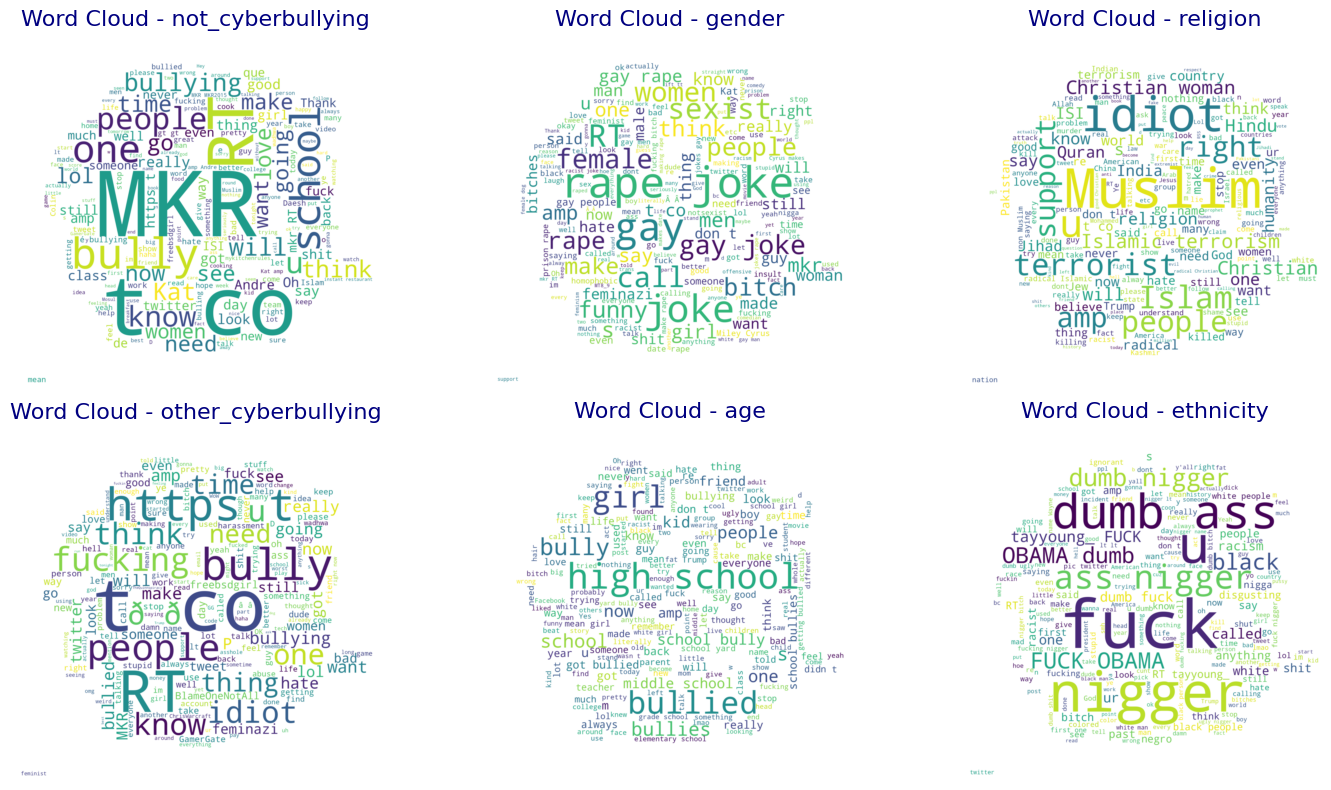

In [ ]:
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import requests



categories = data['cyberbullying_type'].unique()
plt.figure(figsize=(15, 8))
for i, category in enumerate(categories):
    text = data[data['cyberbullying_type'] == category]['tweet_text'].str.cat(sep=' ')
    mask_url = 'https://media.istockphoto.com/id/1301795370/vector/concept-victim-of-bullying-cyber-harassment-cyberstalking-portrait-of-woman-with-frustration.jpg?s=2048x2048&w=is&k=20&c=eAWFdAWd_VYXCvCa_iuP8TV9t3sOuaZqt2NK-ws6M9w='
    mask = np.array(Image.open(BytesIO(requests.get(mask_url).content)))
    wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask).generate(text)
    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {category}', fontsize=16, color='navy')
    plt.axis('off')
plt.tight_layout()
plt.show()

A final consideration, looking at the wordclouds. Judging this graphs by the words that appear for each class, we can see that gender, religion, age and ethnicity classes have words that can be semantically connected with the concept of the cyberbullying act, whereas other cyberbullying and not cyberbullying do not have this property: this anticipate that these 2 labels will be very difficult to be classified.

Moreover, it is necessary to consider the false flagging phenomenon in which, - quoting Jurafsky -, "researchers have shown that some widely used toxicity classifiers incorrectly flag as being toxic sentences that are non-toxic but simply mention minority identities or simply use linguistic features characteristic of varieties. Such false positive errors, if employed by toxicity detection systems without human oversight, could lead to the censoring of discourse by or about these groups. These model problems can be caused by biases or other problems in the training data; in general, machine learning systems replicate and even amplify the biases in their training data. But these problems can also be caused by the labels (for example due to biases in the human labelers), by the resources used (like lexicons, or model components like pretrained embeddings), or even by model architecture."